Importing the necessaries

In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.ensemble import IsolationForest
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
import torch
import xgboost as xgb

Loading the dataset from disk

In [46]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Generating test split: 100%|██████████| 4174/4174 [00:00<00:00, 198742.46 examples/s]


Inspecting data

In [47]:
train_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,mai taci,1,0,0,0,0
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0
3,el e in high elo,1,0,0,0,0
4,ai vol iu,1,0,0,0,0


In [48]:
test_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,giorgii,1,0,0,0,0
1,atata timp cat nu dau tag la euneeuw pur si s...,1,0,0,0,0
2,duoq,1,0,0,0,0
3,Ar trebui sa il stii atunci,1,0,0,0,0
4,nu e din ala,1,0,0,0,0


Converting the dataset to pandas for easier analysis

In [49]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,16700.000000,16700.000000,16700.000000,16700.000000,16700.000000
mean,0.464192,0.451078,0.117305,0.192695,0.138323
std,0.498731,0.497616,0.321793,0.394427,0.345249
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
df_test.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,4174.000000,4174.000000,4174.000000,4174.000000,4174.000000
mean,0.464063,0.451366,0.125299,0.188548,0.139435
std,0.498767,0.497689,0.331098,0.391196,0.346441
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16700 entries, 0 to 16699
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   16700 non-null  object
 1   OK        16700 non-null  int64 
 2   Aggro     16700 non-null  int64 
 3   Violence  16700 non-null  int64 
 4   Sexual    16700 non-null  int64 
 5   Hateful   16700 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 782.9+ KB


In [52]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4174 entries, 0 to 4173
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   4174 non-null   object
 1   OK        4174 non-null   int64 
 2   Aggro     4174 non-null   int64 
 3   Violence  4174 non-null   int64 
 4   Sexual    4174 non-null   int64 
 5   Hateful   4174 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 195.8+ KB


In [53]:
df_train.isnull().sum()

Message     0
OK          0
Aggro       0
Violence    0
Sexual      0
Hateful     0
dtype: int64

In [54]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (16700, 6)
Test shape:  (4174, 6)


In [55]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 310
Number of duplicated instances in test: 23


In [56]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK     Aggro  Violence    Sexual   Hateful
OK        1.000000 -0.843751 -0.287072 -0.404202 -0.350317
Aggro    -0.843751  1.000000  0.142610  0.302185  0.247135
Violence -0.287072  0.142610  1.000000  0.068653  0.092724
Sexual   -0.404202  0.302185  0.068653  1.000000  0.052276
Hateful  -0.350317  0.247135  0.092724  0.052276  1.000000


Data visualization

In [57]:
import matplotlib.pyplot as plt # importing the neccessary library

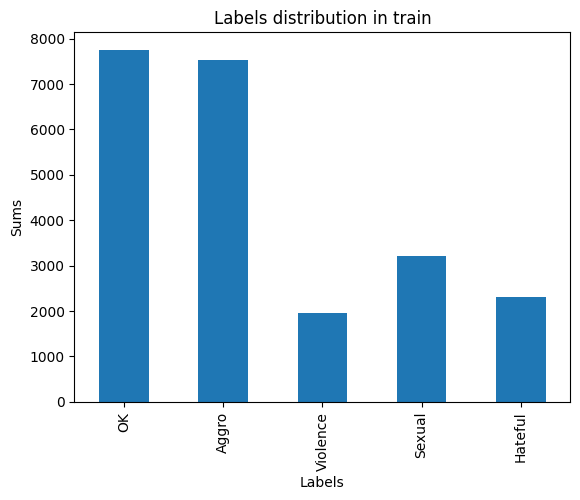

OK          7752
Aggro       7533
Violence    1959
Sexual      3218
Hateful     2310
dtype: int64


In [58]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

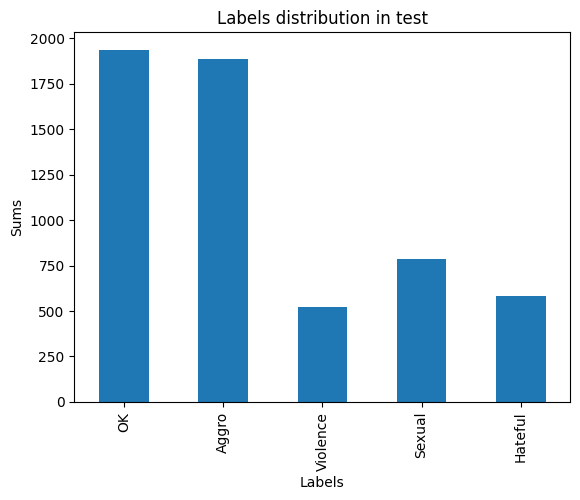

OK          1937
Aggro       1884
Violence     523
Sexual       787
Hateful      582
dtype: int64


In [59]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

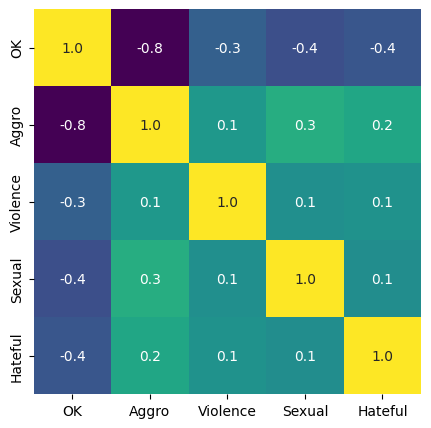

In [60]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

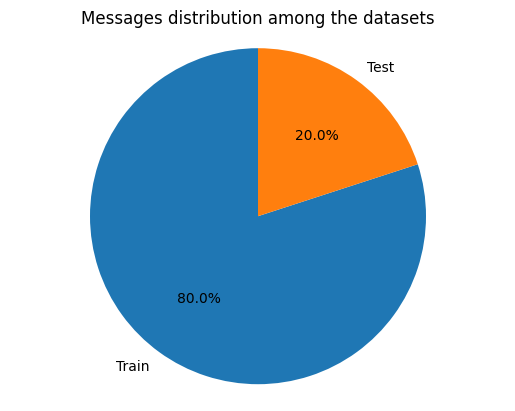

[16700, 4174]


In [61]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Model evaluation

In [62]:
accuracy_array = []
models_used = ['opjlm']

### My model

In [63]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/dataset', dataset_name='rootblind/opjustice-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [64]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.6)] = 1
        return predictions

In [65]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/v1', # 8 epochs 16 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

In [66]:
tokenizer = AutoTokenizer.from_pretrained('./model_versions/v1')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

Map: 100%|██████████| 4174/4174 [00:01<00:00, 2307.98 examples/s]


In [67]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [68]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

In [69]:
f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

F1 Score: 0.9148974451241454
Precision: 0.9411438089950028
Recall: 0.8900752669350603
Accuracy: 0.8310972688068998
ROC AUC: 0.9098615359010884


In [70]:
multilabel_confusion_matrix(y_test, y_pred)

array([[[2149,   88],
        [ 133, 1804]],

       [[2185,  105],
        [ 111, 1773]],

       [[3602,   49],
        [ 166,  357]],

       [[3354,   33],
        [  86,  701]],

       [[3549,   43],
        [ 132,  450]]], dtype=int64)

### Setting Xs and ys

In [71]:
# calling the vectorizer to encode the announcements
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(16700, 31090)


In [72]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(4174, 31090)

### Isolation Forest

In [73]:
clf =  IsolationForest(n_estimators=50, max_samples="auto", random_state=42, contamination=float(0.1))

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train.toarray())

clf.fit(X_train_2d)

IsolationForest(contamination=0.1, n_estimators=50, random_state=42)

In [74]:
df_train['scores'] = clf.decision_function(X_train_2d)
df_train['anomaly'] = clf.predict(X_train_2d)

df_train.head(20)

,Message,OK,Aggro,Violence,Sexual,Hateful,scores,anomaly
0,mai taci,1,0,0,0,0,0.094673,1
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0,0.073875,1
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0,0.118378,1
3,el e in high elo,1,0,0,0,0,0.125676,1
4,ai vol iu,1,0,0,0,0,0.136933,1
5,player exceptional,1,0,0,0,0,0.157813,1
6,a durat cv,1,0,0,0,0,0.156720,1
7,Same,1,0,0,0,0,0.153064,1
8,de unde stii ca i fata,1,0,0,0,0,0.102854,1
9,rateaz q ul ca tine,1,0,0,0,0,0.091244,1


In [75]:
anomaly = df_train.loc[df_train['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)

                                                Message  OK  Aggro  Violence  \
15                                  Am laptopul stricat   1      0         0   
23                                                 n am   1      0         0   
25     e ok bro nu e ca si cum ai fi tu un mare jucator   1      0         0   
47                                          ti am zis o   1      0         0   
61                                         nu l inchizi   1      0         0   
...                                                 ...  ..    ...       ...   
16372                                              muie   0      0         0   
16484         dar femeile nu sunt oameni, asa ca e bine   0      0         0   
16590          dar femeile sunt nu asa oameni ca bine e   0      0         0   
16598          dar femeile nu sunt oameni asa ca e bine   0      0         0   
16608              sunt gelos ca n am cancer ca tine da   0      0         0   

       Sexual  Hateful    scores  anoma

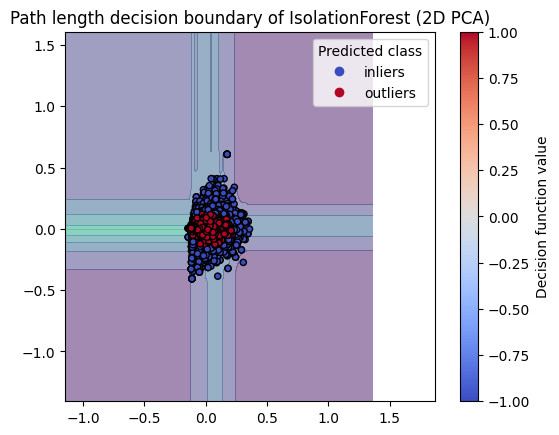

In [76]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train_2d,
    response_method="decision_function",
    alpha=0.5,
)

y_pred = clf.predict(X_train_2d)  # -1 for outliers, 1 for inliers
scatter = disp.ax_.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")

disp.ax_.set_title("Path length decision boundary of IsolationForest (2D PCA)")
plt.axis("square")

# Legend for predicted classes
plt.legend(handles=scatter.legend_elements()[0], labels=["inliers", "outliers"], title="Predicted class")

# Add a color bar for the decision boundary
plt.colorbar(disp.ax_.collections[1], ax=disp.ax_, label="Decision function value")

plt.show()

df_train.drop(columns=['scores', 'anomaly'], inplace=True)

### Other algorithms

In [77]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
multi_target_model = MultiOutputClassifier(xgb_model)
multi_target_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [78]:
y_pred = multi_target_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('XGBClassifier')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1937
           1       0.93      0.83      0.88      1884
           2       0.97      0.51      0.67       523
           3       0.99      0.71      0.83       787
           4       0.99      0.58      0.73       582

   micro avg       0.90      0.79      0.84      5713
   macro avg       0.94      0.71      0.80      5713
weighted avg       0.91      0.79      0.84      5713
 samples avg       0.86      0.82      0.83      5713



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [79]:
model = MultiOutputClassifier(RandomForestClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier())

In [80]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('R.Forest')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1937
           1       0.85      0.88      0.86      1884
           2       0.99      0.61      0.76       523
           3       1.00      0.76      0.87       787
           4       0.99      0.65      0.78       582

   micro avg       0.90      0.81      0.85      5713
   macro avg       0.94      0.75      0.83      5713
weighted avg       0.91      0.81      0.85      5713
 samples avg       0.86      0.82      0.83      5713



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [81]:
model = MultiOutputClassifier(GaussianNB())
model.fit(X_train.toarray(), y_train)

MultiOutputClassifier(estimator=GaussianNB())

In [82]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('GaussianNB')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.41
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1937
           1       0.88      0.85      0.86      1884
           2       0.22      0.73      0.33       523
           3       0.30      0.82      0.44       787
           4       0.26      0.79      0.39       582

   micro avg       0.50      0.84      0.63      5713
   macro avg       0.50      0.81      0.58      5713
weighted avg       0.66      0.84      0.71      5713
 samples avg       0.63      0.85      0.67      5713



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [83]:
model = MultiOutputClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier())

In [84]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('DT')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1937
           1       0.78      0.86      0.82      1884
           2       0.83      0.77      0.80       523
           3       0.89      0.85      0.87       787
           4       0.89      0.86      0.87       582

   micro avg       0.83      0.82      0.82      5713
   macro avg       0.85      0.82      0.83      5713
weighted avg       0.83      0.82      0.82      5713
 samples avg       0.79      0.80      0.78      5713



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
model = MultiOutputClassifier(LogisticRegression())
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [86]:
y_pred = model.predict(X_test.toarray())
accuracy = accuracy_score(y_test, y_pred)
accuracy_array.append(accuracy)
models_used.append('LR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1937
           1       0.89      0.86      0.88      1884
           2       0.93      0.24      0.38       523
           3       0.93      0.52      0.67       787
           4       0.95      0.31      0.46       582

   micro avg       0.89      0.70      0.79      5713
   macro avg       0.92      0.56      0.65      5713
weighted avg       0.90      0.70      0.76      5713
 samples avg       0.83      0.75      0.77      5713



c:\root\Projects\python\opjustice-lm\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Comparing accuracy between algorithms

<BarContainer object of 6 artists>

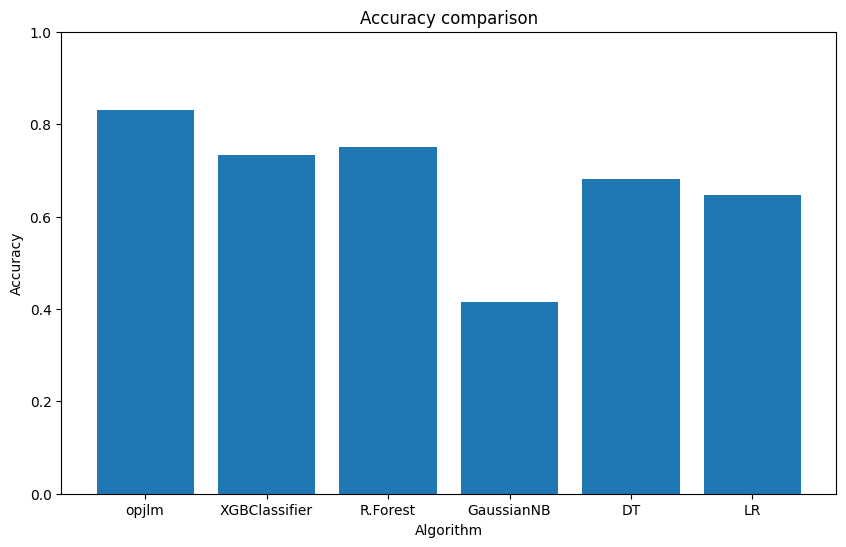

In [87]:
plt.figure(figsize=(10,6))
plt.title('Accuracy comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.bar(models_used, accuracy_array)

It takes over 8GB of RAM just to fit the model, run this cell when you don't need your computer for several minutes.

In [88]:
"""
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

model.fit(X_train.toarray(), y_train)
y_pred = model.predict(X_test.toarray())
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
accuracy_array.append(accuracy)
models_used.append('GPR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_binary))
"""

"\nfrom sklearn.gaussian_process.kernels import DotProduct, WhiteKernel\nkernel = DotProduct() + WhiteKernel()\nmodel = GaussianProcessRegressor(kernel=kernel, random_state=42)\n\nmodel.fit(X_train.toarray(), y_train)\ny_pred = model.predict(X_test.toarray())\ny_pred_binary = (y_pred > 0.5).astype(int)\naccuracy = accuracy_score(y_test, y_pred_binary)\naccuracy_array.append(accuracy)\nmodels_used.append('GPR')\nprint(f'Accuracy: {accuracy:.2f}')\nprint(classification_report(y_test, y_pred_binary))\n"